In [3]:
%matplotlib inline

In [4]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [5]:
import pandas as pd
adhd_df = pd.read_csv("C:\\Users\\joshi\\Downloads\\ADHD.csv",low_memory=False)
nonadhd_df = pd.read_csv("C:\\Users\\joshi\\Downloads\\NonAdhd.csv",low_memory=False)

In [6]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
adhd_df['text'] = (adhd_df['title'].fillna('') + ' ' + adhd_df['selftext'].fillna(''))
adhd_df['label'] = 1

nonadhd_df['text'] = nonadhd_df['body'].fillna('')
nonadhd_df['label'] = 0

adhd_df = adhd_df[['text', 'label']]
nonadhd_df = nonadhd_df[['text', 'label']]

df = pd.concat([adhd_df, nonadhd_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

In [9]:
print(df.tail())

                                                    text  label
19993                i agree it was stuffed with content      0
19994  disappointing that youre trying to troll durin...      0
19995  and i think i haveaddhd im and gay just saying...      1
19996  vyvanse dosagelisdexamfetamine ok so i have be...      1
19997               this was actually enjoyable to watch      0


In [10]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print(X_train.shape, y_train.shape)

(15998, 5000) (15998,)


In [12]:
from scipy.sparse import issparse
print("Is X_train sparse?", issparse(X_train))

Is X_train sparse? True


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import time

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "SVM": SVC(kernel="linear", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=10),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_estimators=10),
    "AdaBoost": AdaBoostClassifier(n_estimators=10),
}

for name, model in models.items():
    print(f"\nFitting {name}...")
    try:
        t1 = time.time()
        model.fit(X_train_scaled, y_train)
        t2 = time.time()
        print(f"{name} trained in {round(t2 - t1, 2)}s.")
        models[name] = model 
    except Exception as e:
        print(f"{name} failed: {e}")


Fitting SVM...
SVM trained in 100.63s.

Fitting Random Forest...
Random Forest trained in 1.76s.

Fitting XGBoost...
XGBoost trained in 1.28s.

Fitting AdaBoost...
AdaBoost trained in 0.84s.



 Evaluating SVM...
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1968
           1       0.87      0.91      0.89      2032

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



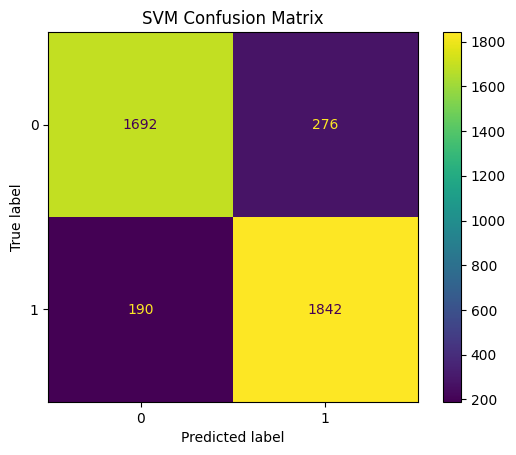


 Evaluating Random Forest...
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1968
           1       0.96      0.93      0.95      2032

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



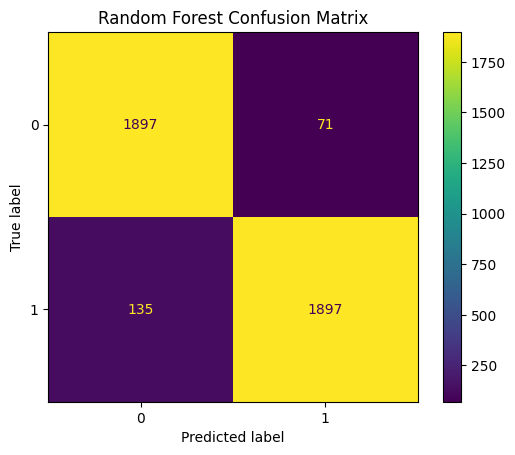


 Evaluating XGBoost...
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1968
           1       0.99      0.87      0.92      2032

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



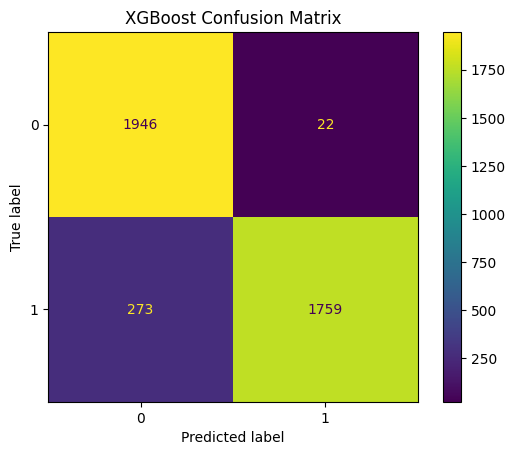


 Evaluating AdaBoost...
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1968
           1       1.00      0.61      0.76      2032

    accuracy                           0.80      4000
   macro avg       0.86      0.80      0.79      4000
weighted avg       0.86      0.80      0.79      4000



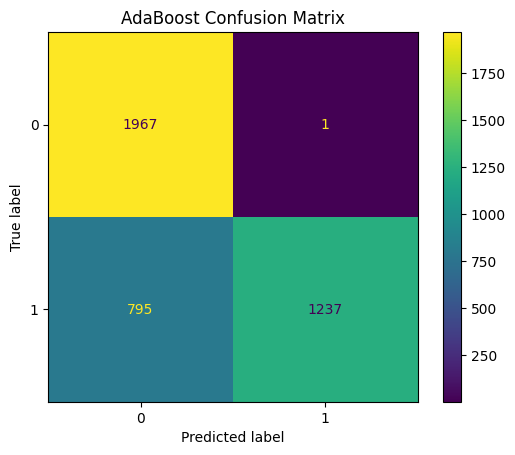

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    print(f"\n Evaluating {name}...")

    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred, zero_division=0))


    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{name} Confusion Matrix')
    plt.grid(False)
    plt.show()


Computing ROC curve for SVM...

Computing ROC curve for Random Forest...

Computing ROC curve for XGBoost...

Computing ROC curve for AdaBoost...


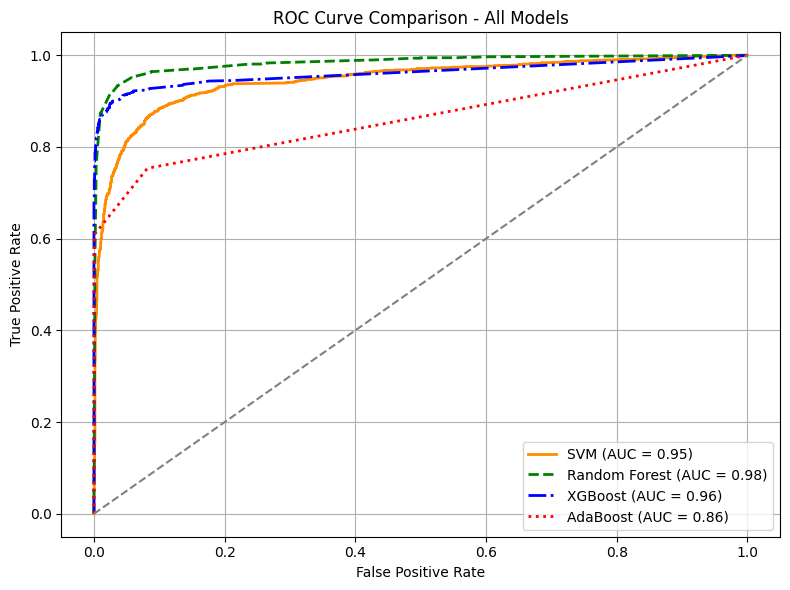

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

colors = ['darkorange', 'green', 'blue', 'red']
linestyles = ['-', '--', '-.', ':']

for idx, (name, model) in enumerate(models.items()):
    try:
        print(f"\nComputing ROC curve for {name}...")
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[idx % len(colors)],
                 linestyle=linestyles[idx % len(linestyles)],
                 lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    except Exception as e:
        print(f"{name} failed during ROC computation: {e}")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 300

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True)
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = np.array(df['label'])

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(data, labels, test_size=0.2, random_state=42)

In [17]:
EMBEDDING_DIM = 64
BATCH_SIZE = 64
EPOCHS = 10

lstm_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=300),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


lstm_model.fit(X_train_dl, y_train_dl,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               validation_data=(X_test_dl, y_test_dl),
               verbose=1)

Epoch 1/10
250/250 [==============================] - 129s 494ms/step - loss: 0.3530 - accuracy: 0.8486 - val_loss: 0.1208 - val_accuracy: 0.9653
Epoch 2/10
250/250 [==============================] - 119s 477ms/step - loss: 0.0912 - accuracy: 0.9728 - val_loss: 0.1061 - val_accuracy: 0.9665
Epoch 3/10
250/250 [==============================] - 126s 505ms/step - loss: 0.0585 - accuracy: 0.9823 - val_loss: 0.1015 - val_accuracy: 0.9715
Epoch 4/10
250/250 [==============================] - 151s 604ms/step - loss: 0.0495 - accuracy: 0.9863 - val_loss: 0.1069 - val_accuracy: 0.9690
Epoch 5/10
250/250 [==============================] - 119s 475ms/step - loss: 0.0343 - accuracy: 0.9902 - val_loss: 0.1201 - val_accuracy: 0.9653
Epoch 6/10
250/250 [==============================] - 116s 464ms/step - loss: 0.0251 - accuracy: 0.9929 - val_loss: 0.1202 - val_accuracy: 0.9647
Epoch 7/10
250/250 [==============================] - 118s 473ms/step - loss: 0.0199 - accuracy: 0.9945 - val_loss: 0.1282 -

In [18]:
lstm_model.save("lstm_model.h5")


===== LSTM Evaluation =====
125/125 [==============================] - 40s 311ms/step
LSTM Accuracy: 0.9572

LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1968
           1       0.95      0.97      0.96      2032

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



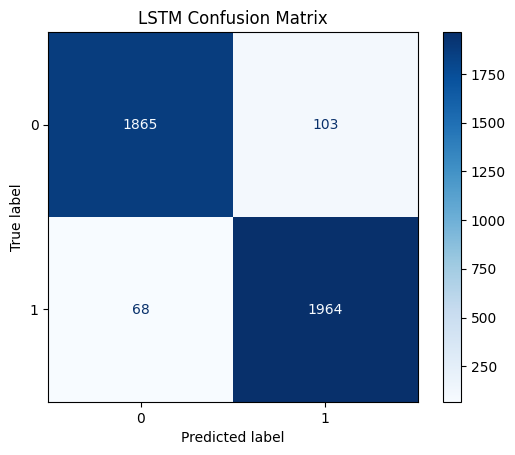

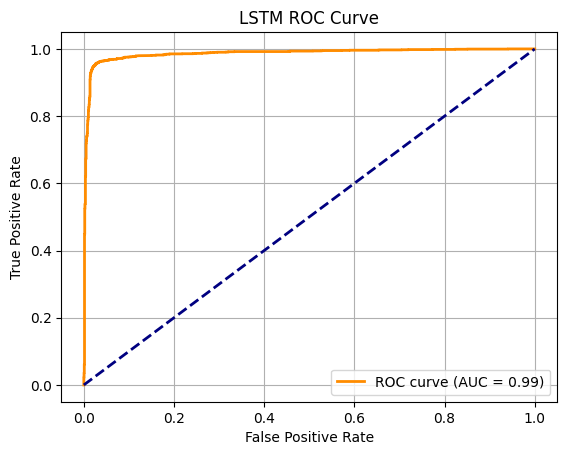

In [19]:
from sklearn.metrics import roc_curve, auc
def evaluate_model(name, model, X_test, y_test):
    print(f"\n===== {name} Evaluation =====")

    X_test = np.array(X_test)
    y_test = np.array(y_test).reshape(-1)

    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name} Accuracy: {acc:.4f}")

    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.grid(False)
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure() 
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

evaluate_model("LSTM", lstm_model, X_test_dl, y_test_dl)

Summary of Model Performance

Random Forest and LSTM emerged as the top performers, achieving 95% and 96% accuracy, respectively. XGBoost and SVM also demonstrated strong predictive capabilities with accuracies of 93% and 88%, while AdaBoost performed the least, likely due to its sensitivity to class imbalance. The LSTM model exhibited excellent generalization but showed minor overfitting after a few epochs. Key challenges during implementation included handling noisy user-generated Reddit data and the reduced interpretability of deep learning models like LSTM. Despite these challenges, the results indicate that both traditional machine learning and deep learning approaches can effectively distinguish between ADHD and non-ADHD posts. With further tuning and external validation, these models show great promise for supporting early mental health screening and intervention.